# 23장. 추천 시스템 (Recommender Systems)

## 1. 인기 순위로 추천

### 1.1 데이터셋 정의

In [1]:
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

### 1.2 관심 종목 인기 순위

In [2]:
from collections import Counter

popular_interests = Counter(interest
                            for user_interests in users_interests
                            for interest in user_interests)
print(popular_interests)

Counter({'Python': 4, 'R': 4, 'Big Data': 3, 'HBase': 3, 'Java': 3, 'statistics': 3, 'regression': 3, 'probability': 3, 'Hadoop': 2, 'Cassandra': 2, 'MongoDB': 2, 'Postgres': 2, 'scikit-learn': 2, 'statsmodels': 2, 'pandas': 2, 'machine learning': 2, 'libsvm': 2, 'C++': 2, 'neural networks': 2, 'deep learning': 2, 'artificial intelligence': 2, 'Spark': 1, 'Storm': 1, 'NoSQL': 1, 'scipy': 1, 'numpy': 1, 'decision trees': 1, 'Haskell': 1, 'programming languages': 1, 'mathematics': 1, 'theory': 1, 'Mahout': 1, 'MapReduce': 1, 'databases': 1, 'MySQL': 1, 'support vector machines': 1})


### 1.3 인기 순위로 추천

In [3]:
from typing import Dict, List, Tuple

def most_popular_new_interests(
        user_interests: List[str],
        max_results: int = 5) -> List[Tuple[str, int]]:
    suggestions = [(interest, frequency)
                   for interest, frequency in popular_interests.most_common()
                   if interest not in user_interests]
    return suggestions[:max_results]

In [4]:
print(most_popular_new_interests(users_interests[1]))

[('Python', 4), ('R', 4), ('Big Data', 3), ('Java', 3), ('statistics', 3)]


## 2. 사용자 기반 협업 필터링 (User-Based Collaborative Filtering)

### 2.1 관심사 목록 

In [5]:
unique_interests = sorted({interest
                           for user_interests in users_interests
                           for interest in user_interests})

print(unique_interests)
assert unique_interests[:6] == [
    'Big Data',
    'C++',
    'Cassandra',
    'HBase',
    'Hadoop',
    'Haskell',
    # ...
]

['Big Data', 'C++', 'Cassandra', 'HBase', 'Hadoop', 'Haskell', 'Java', 'Mahout', 'MapReduce', 'MongoDB', 'MySQL', 'NoSQL', 'Postgres', 'Python', 'R', 'Spark', 'Storm', 'artificial intelligence', 'databases', 'decision trees', 'deep learning', 'libsvm', 'machine learning', 'mathematics', 'neural networks', 'numpy', 'pandas', 'probability', 'programming languages', 'regression', 'scikit-learn', 'scipy', 'statistics', 'statsmodels', 'support vector machines', 'theory']


### 2.2 사용자 별 관심사 벡터

In [6]:
def make_user_interest_vector(user_interests: List[str]) -> List[int]:
    """
    Given a list ofinterests, produce a vector whose ith element is 1
    if unique_interests[i] is in the list, 0 otherwise
    """
    return [1 if interest in user_interests else 0
            for interest in unique_interests]

In [7]:
user_interest_vectors = [make_user_interest_vector(user_interests)
                         for user_interests in users_interests]

### 2.3 사용자 유사도 행렬

#### 2.3.1 코사인 유사도 (cosine similarity)

In [8]:
from scratch.linear_algebra import dot, Vector
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

#### 2.3.2 사용자 유사도 행렬

In [9]:
user_similarities = [[cosine_similarity(interest_vector_i, interest_vector_j)
                      for interest_vector_j in user_interest_vectors]
                     for interest_vector_i in user_interest_vectors]

In [10]:
# Users 0 and 9 share interests in Hadoop, Java, and Big Data
assert 0.56 < user_similarities[0][9] < 0.58, "several shared interests"

# Users 0 and 8 share only one interest: Big Data
assert 0.18 < user_similarities[0][8] < 0.20, "only one shared interest"

### 2.4 유사한 사용자 목록

In [11]:
def most_similar_users_to(user_id: int) -> List[Tuple[int, float]]:
    pairs = [(other_user_id, similarity)                      # Find other
             for other_user_id, similarity in                 # users with
                enumerate(user_similarities[user_id])         # nonzero
             if user_id != other_user_id and similarity > 0]  # similarity.

    return sorted(pairs,                                      # Sort them
                  key=lambda pair: pair[-1],                  # most similar
                  reverse=True)                               # first.

In [12]:
most_similar_to_zero = most_similar_users_to(0)
print(most_similar_to_zero)
user, score = most_similar_to_zero[0]
assert user == 9
assert 0.56 < score < 0.57
user, score = most_similar_to_zero[1]
assert user == 1
assert 0.33 < score < 0.34

[(9, 0.5669467095138409), (1, 0.3380617018914066), (8, 0.1889822365046136), (13, 0.1690308509457033), (5, 0.1543033499620919)]


### 2.5 사용자 기반 추천

In [13]:
from collections import defaultdict

def user_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Sum up the similarities.
    suggestions: Dict[str, float] = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity

    # Convert them to a sorted list.
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],  # weight
                         reverse=True)

    # And (maybe) exclude already-interests
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [14]:
ubs0 = user_based_suggestions(0)
print(ubs0)
interest, score = ubs0[0]
assert interest == 'MapReduce'
assert 0.56 < score < 0.57
interest, score = ubs0[1]
assert interest == 'MongoDB'
assert 0.50 < score < 0.51

[('MapReduce', 0.5669467095138409), ('MongoDB', 0.50709255283711), ('Postgres', 0.50709255283711), ('NoSQL', 0.3380617018914066), ('neural networks', 0.1889822365046136), ('deep learning', 0.1889822365046136), ('artificial intelligence', 0.1889822365046136), ('databases', 0.1690308509457033), ('MySQL', 0.1690308509457033), ('Python', 0.1543033499620919), ('R', 0.1543033499620919), ('C++', 0.1543033499620919), ('Haskell', 0.1543033499620919), ('programming languages', 0.1543033499620919)]


## 3. 아이템 기반 협업 필터링 (Item-Based Collaborative Filtering)

### 3.1 아이템-사용자 행렬

In [15]:
interest_user_matrix = [[user_interest_vector[j]
                         for user_interest_vector in user_interest_vectors]
                        for j, _ in enumerate(unique_interests)]

In [16]:
interest_user_matrix[0]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

### 3.2 아이템 유사도 행렬

In [17]:
interest_similarities = [[cosine_similarity(user_vector_i, user_vector_j)
                          for user_vector_j in interest_user_matrix]
                         for user_vector_i in interest_user_matrix]

### 3.3 유사한 아이템 목록

In [18]:
def most_similar_interests_to(interest_id: int):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda pair: pair[-1],
                  reverse=True)

In [19]:
msit0 = most_similar_interests_to(0)
print(msit0)
assert msit0[0][0] == 'Hadoop'
assert 0.815 < msit0[0][1] < 0.817
assert msit0[1][0] == 'Java'
assert 0.666 < msit0[1][1] < 0.667

[('Hadoop', 0.8164965809277261), ('Java', 0.6666666666666666), ('MapReduce', 0.5773502691896258), ('Spark', 0.5773502691896258), ('Storm', 0.5773502691896258), ('Cassandra', 0.4082482904638631), ('artificial intelligence', 0.4082482904638631), ('deep learning', 0.4082482904638631), ('neural networks', 0.4082482904638631), ('HBase', 0.3333333333333333)]


### 3.4 아이템 기반 추천

In [20]:
def item_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Add up the similar interests
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_vectors[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    # Sort them by weight
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]


In [21]:
ibs0 = item_based_suggestions(0)
print(ibs0)
assert ibs0[0][0] == 'MapReduce'
assert 1.86 < ibs0[0][1] < 1.87
assert ibs0[1][0] in ('Postgres', 'MongoDB')  # A tie
assert 1.31 < ibs0[1][1] < 1.32

[('MapReduce', 1.861807319565799), ('MongoDB', 1.3164965809277263), ('Postgres', 1.3164965809277263), ('NoSQL', 1.2844570503761732), ('MySQL', 0.5773502691896258), ('databases', 0.5773502691896258), ('Haskell', 0.5773502691896258), ('programming languages', 0.5773502691896258), ('artificial intelligence', 0.4082482904638631), ('deep learning', 0.4082482904638631), ('neural networks', 0.4082482904638631), ('C++', 0.4082482904638631), ('Python', 0.2886751345948129), ('R', 0.2886751345948129)]


## 4. 잠재 요인 기반 협업 필터링

### 4.1 데이터 타입 정의

#### 4.1.1 평점 파일 경로

In [22]:
# This points to the current directory, modify if your files are elsewhere.
MOVIES = "ml-100k\\u.item"   # pipe-delimited: movie_id|title|...
RATINGS = "ml-100k\\u.data"  # tab-delimited: user_id, movie_id, rating, timestamp

#### 4.1.2 평점 NamedTuple

In [23]:
from typing import NamedTuple

class Rating(NamedTuple):
    user_id: str
    movie_id: str
    rating: float

### 4.2 데이터 읽기

In [24]:
import csv
# We specify this encoding to avoid a UnicodeDecodeError.
# see: https://stackoverflow.com/a/53136168/1076346
with open(MOVIES, encoding="iso-8859-1") as f:
    reader = csv.reader(f, delimiter="|")
    movies = {movie_id: title for movie_id, title, *_ in reader}

# Create a list of [Rating]
with open(RATINGS, encoding="iso-8859-1") as f:
    reader = csv.reader(f, delimiter="\t")
    ratings = [Rating(user_id, movie_id, float(rating))
                for user_id, movie_id, rating, _ in reader]

# 1682 movies rated by 943 users
assert len(movies) == 1682
assert len(list({rating.user_id for rating in ratings})) == 943

### 4.3 데이터 탐색 (스타워즈 평점 확인)

In [25]:
import re

# Data structure for accumulating ratings by movie_id
star_wars_ratings = {movie_id: []
                        for movie_id, title in movies.items()
                        if re.search("Star Wars|Empire Strikes|Jedi", title)}

# Iterate over ratings, accumulating the Star Wars ones
for rating in ratings:
    if rating.movie_id in star_wars_ratings:
        star_wars_ratings[rating.movie_id].append(rating.rating)

# Compute the average rating for each movie
avg_ratings = [(sum(title_ratings) / len(title_ratings), movie_id)
                for movie_id, title_ratings in star_wars_ratings.items()]

# And then print them in order
for avg_rating, movie_id in sorted(avg_ratings, reverse=True):
    print(f"{avg_rating:.2f} {movies[movie_id]}")

4.36 Star Wars (1977)
4.20 Empire Strikes Back, The (1980)
4.01 Return of the Jedi (1983)


### 4.4 데이터 분리

In [26]:
import random
random.seed(0)
random.shuffle(ratings)

split1 = int(len(ratings) * 0.7)
split2 = int(len(ratings) * 0.85)

train = ratings[:split1]              # 70% of the data
validation = ratings[split1:split2]   # 15% of the data
test = ratings[split2:]               # 15% of the data

### 4.5 베이스라인 생성

In [27]:
avg_rating = sum(rating.rating for rating in train) / len(train)
baseline_error = sum((rating.rating - avg_rating) ** 2
                        for rating in test) / len(test)

print(avg_rating)
print(baseline_error)

# This is what we hope to do better than
assert 1.26 < baseline_error < 1.27

3.530842857142857
1.2609526646939684


### 4.6 임베딩 생성

In [28]:
# Embedding vectors for matrix factorization model

from scratch.deep_learning import random_tensor

EMBEDDING_DIM = 2

# Find unique ids
user_ids = {rating.user_id for rating in ratings}
movie_ids = {rating.movie_id for rating in ratings}

# Then create a random vector per id
user_vectors = {user_id: random_tensor(EMBEDDING_DIM)
                for user_id in user_ids}
movie_vectors = {movie_id: random_tensor(EMBEDDING_DIM)
                    for movie_id in movie_ids}

<Figure size 432x288 with 0 Axes>

### 4.7 모델 학습

In [29]:
# Training loop for matrix factorization model

from typing import List
from tqdm.notebook import tqdm
from scratch.linear_algebra import dot

def fit(dataset: List[Rating],
            learning_rate: float = None) -> float:
    loss = 0.0
    for i, rating in enumerate(dataset):
        movie_vector = movie_vectors[rating.movie_id]
        user_vector = user_vectors[rating.user_id]
        predicted = dot(user_vector, movie_vector)
        error = predicted - rating.rating
        loss += error ** 2

        if learning_rate is not None:
            #     predicted = m_0 * u_0 + ... + m_k * u_k
            # So each u_j enters output with coefficent m_j
            # and each m_j enters output with coefficient u_j
            user_gradient = [2*error*m_j for m_j in movie_vector]
            movie_gradient = [2*error*u_j for u_j in user_vector]

            # Take gradient steps
            for j in range(EMBEDDING_DIM):
                user_vector[j] -= learning_rate * user_gradient[j]
                movie_vector[j] -= learning_rate * movie_gradient[j]
    return loss/len(dataset)

In [30]:
def evaluate(dataset: List[Rating]) -> float:
    loss = 0.0
    for i, rating in enumerate(dataset):
        movie_vector = movie_vectors[rating.movie_id]
        user_vector = user_vectors[rating.user_id]
        predicted = dot(user_vector, movie_vector)
        error = predicted - rating.rating
        loss += error ** 2
    return loss/len(dataset)

In [31]:
from tqdm import trange, tqdm
epoch = 20
learning_rate = 0.05

train_history = []
validation_history = []
with trange(epoch) as t:
    for epoch in t:
        learning_rate *= 0.9
        train_loss = fit(train, learning_rate=learning_rate)
        valid_loss = evaluate(validation)
        t.set_description(f"epoch : {epoch}, train loss: {train_loss :.2f}, valid loss: {valid_loss :.2f}")
        train_history.append(train_loss)
        validation_history.append(valid_loss)

epoch : 19, train loss: 0.80, valid loss: 0.90: 100%|██████████████████████████████████| 20/20 [00:05<00:00,  3.70it/s]


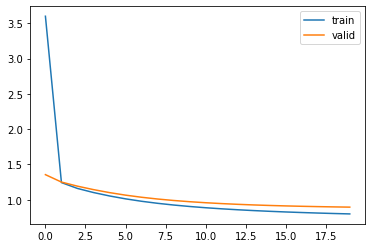

In [32]:
import matplotlib.pyplot as plt
plt.plot(train_history, label="train")
plt.plot(validation_history, label='valid')
plt.legend()
plt.show()

### 4.8 모델 테스트

In [33]:
test_loss = evaluate(test)
print(f"baseline error : {baseline_error}, predicted error : {test_loss}")

baseline error : 1.2609526646939684, predicted error : 0.9055570858779906


### 4.9 영화 임베딩 주성분 분석

dv: 956.953: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.96it/s]


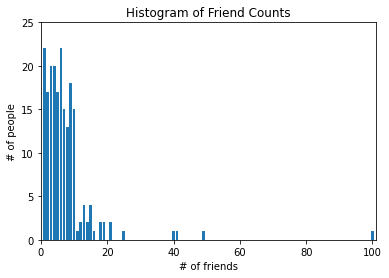

In [34]:
from scratch.working_with_data import pca, transform
original_vectors = [vector for vector in movie_vectors.values()]
components = pca(original_vectors, 2)

#### 4.9.1 주성분으로 사영

In [35]:
ratings_by_movie = defaultdict(list)
for rating in ratings:
    ratings_by_movie[rating.movie_id].append(rating.rating)

vectors = [
    (movie_id,
        sum(ratings_by_movie[movie_id]) / len(ratings_by_movie[movie_id]),
        movies[movie_id],
        vector)
    for movie_id, vector in zip(movie_vectors.keys(),
                                transform(original_vectors, components))
]

#### 4.9.2 평점과 임베딩 분포

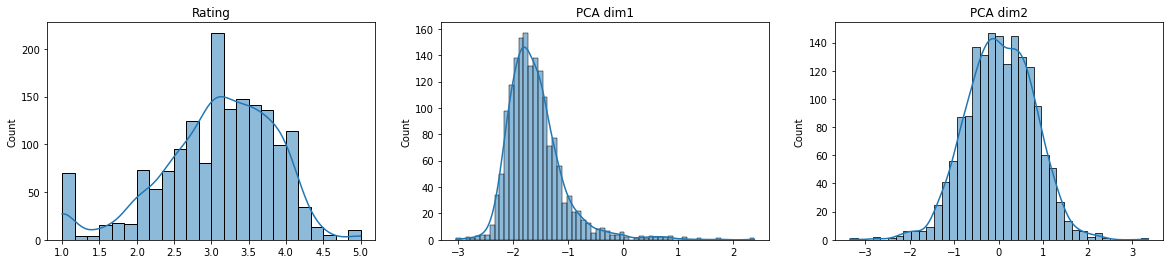

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
ratings = [vector[1] for vector in vectors]
pca_dim1 = [vector[-1][0] for vector in vectors]
pca_dim2 = [vector[-1][1] for vector in vectors]

plt.figure(figsize=[20,4])
plt.subplot(1,3,1)
sns.histplot(data=ratings, kde=True)
plt.title('Rating')
plt.subplot(1,3,2)
sns.histplot(data=pca_dim1, kde=True)
plt.title('PCA dim1')
plt.subplot(1,3,3)
sns.histplot(data=pca_dim2, kde=True)
plt.title('PCA dim2')
plt.show()

#### 4.9.3 평점과 임베딩의 상관성

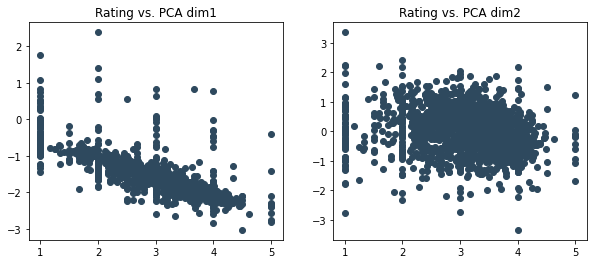

In [37]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.scatter(ratings, pca_dim1, facecolor="#2E495E")
plt.title('Rating vs. PCA dim1')
plt.subplot(1,2,2)
plt.scatter(ratings, pca_dim2, facecolor="#2E495E")
plt.title('Rating vs. PCA dim2')
plt.show()